In [ ]:
import torch
from torch import Tensor
from torch.nn import functional as F
from torch import nn
from torch.distributions.categorical import Categorical
import numpy as np

## Discrete Case

In [ ]:
discrete_truth_1 = torch.tensor([
    [
        0, 1, 0
    ],
    [
        1, 0, 0
    ]
])
discrete_truth_2 = torch.tensor([
    [
        0, 0, 1
    ],
    [
        0, 1, 0
    ]
])
discrete_truth = torch.stack([discrete_truth_1, discrete_truth_2])

In [ ]:
discrete_truth, discrete_truth.shape

(tensor([[[0, 1, 0],
          [1, 0, 0]],
 
         [[0, 0, 1],
          [0, 1, 0]]]),
 torch.Size([2, 2, 3]))

In [ ]:
dis_batch, dis_len, K = discrete_truth.shape

In [ ]:
def dis_beta_t(beta_1, t):
  assert torch.all(t <= 1.0), "all times in `t` must be at most 1"
  assert torch.all(t >= 0.0), "all times in `t` must be at least 0"
  return beta_1 * (t**2)

In [ ]:
def dis_y_distribution(beta: Tensor, K: int, kron_x: Tensor):
  beta_reshaped = beta.view(-1, 1, 1)
  mean = beta_reshaped * (K * kron_x - 1)
  variance = beta_reshaped * K
  eps = torch.normal(0, 1, kron_x.shape)
  return mean + variance * eps

In [ ]:
def dis_t(i: Tensor, n: Tensor, minimum: float=1e-6):
  assert torch.all(i <= n), "i must be less than or equal to n"
  assert torch.all(n > 0), "n must be at least 1"
  assert torch.all(i > 0), "i must be at least 1"
  return torch.clamp((i - 1) / n, min=minimum)

In [ ]:
def dis_theta(y_prime, scaled=True):
  theta = F.softmax(y_prime, dim=-1)
  if scaled:
    theta = 2 * theta - 1
  return theta

### Discrete example of simulated bayesian updates for fast training

In [ ]:
# we'll try batch dimension `n` and `i` to allow different `t` per batch
n = torch.tensor([10, 12])
i = torch.tensor([1, 3])

In [ ]:
dis_beta_1 = torch.tensor([4, 3])

In [ ]:
t = dis_t(i, n)

In [ ]:
t

tensor([1.0000e-06, 1.6667e-01])

In [ ]:
beta = dis_beta_t(dis_beta_1, t)

In [ ]:
beta

tensor([4.0000e-12, 8.3333e-02])

In [ ]:
y_prime = dis_y_distribution(beta, K, discrete_truth)

In [ ]:
y_prime

tensor([[[-2.1192e-11,  2.4212e-11,  4.3637e-12],
         [ 2.2644e-11, -1.4148e-11, -2.0885e-11]],

        [[-1.6869e-01, -2.5021e-01,  4.3492e-01],
         [ 1.1112e-01, -1.4747e-01, -3.6660e-01]]])

In [ ]:
theta = dis_theta(y_prime)

In [ ]:
theta

tensor([[[-0.3333, -0.3333, -0.3333],
         [-0.3333, -0.3333, -0.3333]],

        [[-0.4667, -0.5085, -0.0248],
         [-0.1640, -0.3545, -0.4815]]])

### Discrete Neural Net

In [ ]:
class DiscreteModel(nn.Module):
  def __init__(self, max_seq_len: int, K: int, hidden_dim: int, num_heads: int, layers: int = 3, dropout: float = 0.1):
    super().__init__()
    assert hidden_dim % num_heads == 0, "hidden_dim must be divisble by num_heads"
    self.emb = nn.Parameter(torch.randn(K, hidden_dim))
    self.pos_emb = nn.Parameter(torch.randn(max_seq_len, hidden_dim))
    self.time_emb = nn.Parameter(torch.randn(1, hidden_dim))
    self.layers = nn.ModuleList(
        [
            nn.TransformerEncoderLayer(
                hidden_dim,
                num_heads,
                hidden_dim*4,
                dropout,
                batch_first=True,
                bias=False
                ) for i in range(layers)
        ]
    )
    self.classifier = nn.Parameter(torch.randn(hidden_dim, K))

  def token_emb(self, x):
    return x @ self.emb

  def positional_emb(self, x):
    return x + self.pos_emb[:x.shape[1]]

  def time_emb(self, x, t):
    assert t.ndim == 1, "time vector `t` should be vector of length batch_size"
    return (t.unsqueeze(-1) @ self.time_emb) + x

  def forward(self, x):
    x = self.token_emb(x)
    x = self.positional_emb(x)
    for i, l in enumerate(self.layers):
      x = l.forward(x)
    return x @ self.classifier

In [ ]:
max_seq_len = 2
hidden_dim = 64
num_heads = 8

In [ ]:
dis_model = DiscreteModel(max_seq_len, K, hidden_dim, num_heads)

In [ ]:
dis_output = dis_model.forward(theta)

In [ ]:
dis_output, dis_output.shape

(tensor([[[-1.3763e+00, -1.2909e-02,  3.3054e+00],
          [-9.2694e-01,  2.9095e+00,  1.3046e+01]],
 
         [[ 4.6679e+00,  1.7936e+00,  5.5085e+00],
          [ 1.4874e+00,  2.4814e+00,  1.1952e+01]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 2, 3]))

### Discrete Loss

In [ ]:
dis_output_probs = torch.softmax(dis_output, dim=-1)

In [ ]:
loss = torch.sum(K * dis_beta_1 * t * torch.sum((discrete_truth - dis_output_probs) ** 2) / dis_batch_size)

In [ ]:
K * dis_beta_1 * t * torch.sum((discrete_truth - dis_output_probs) ** 2) / dis_batch

tensor(3.6196e-05, grad_fn=<DivBackward0>)

### Discrete bayesian update step

In [ ]:
def dis_accuracy(i, n, beta_1):
  assert n > 0, "must have at least 1 inference step"
  assert i > 0, "must be at the first inference step or higher"
  assert i <= n, "current inference step must be less than or equal to max inference steps"
  return beta_1 * (2 * i - 1) / (n ** 2)

In [ ]:
def dis_sample_model_output(model_output, one_hot: bool=True):
  batch_size, seq_len, classes = model_output.shape
  dist = Categorical(logits=model_output)
  samples = dist.sample()
  if one_hot:
    samples = F.one_hot(samples, classes)
  return samples

In [ ]:
def dis_y(sampled_one_hot, alpha, use_variance=True):
  # from some brief tests, using the variance results in a smoother decrease
  # in error, while the standard deviation is more erratic but occasionally
  # dips lower faster (but also sometimes goes up much more)
  # when number of inference steps is low (below 10 or so), it seems using standard deviation
  # is better (from the *very* limited tests I have done)
  _, _, classes = sampled_one_hot.shape
  mean = alpha * (classes * sampled_one_hot - 1)
  variance = alpha * classes
  standard_deviation = variance ** 0.5
  coeff = variance if use_variance else standard_deviation
  epsilon = torch.normal(0, 1, sampled_one_hot.shape)
  return mean + coeff * epsilon

In [ ]:
def dis_bayesian_update(sampled_y, model_input):
  res = torch.exp(sampled_y) * model_input
  return res / torch.sum(res, dim=-1, keepdim=True)

In [ ]:
def dis_bayesian_inference(model_input, model_output, i, n, beta_1, use_variance=True):
  batch_size, seq_len, classes = model_output.shape
  alpha = dis_accuracy(i, n, beta_1)
  sampled = dis_sample_model_output(model_output)
  y = dis_y(sampled, alpha, use_variance)
  return dis_bayesian_update(y, model_input)

In [ ]:
torch.manual_seed(32)

In [ ]:
model_input = torch.normal(0, 1, discrete_truth.shape)
model_input = torch.softmax(model_input, dim=-1)

In [ ]:
model_input

tensor([[[0.4661, 0.2019, 0.3319],
         [0.4249, 0.4027, 0.1724]],

        [[0.7074, 0.2504, 0.0423],
         [0.1235, 0.8233, 0.0532]]])

In [ ]:
discrete_truth

tensor([[[0, 1, 0],
         [1, 0, 0]],

        [[0, 0, 1],
         [0, 1, 0]]])

In [ ]:
model_output = discrete_truth * 10 + 0.1 * torch.normal(0, 1, discrete_truth.shape)

In [ ]:
model_input, model_output

(tensor([[[0.4661, 0.2019, 0.3319],
          [0.4249, 0.4027, 0.1724]],
 
         [[0.7074, 0.2504, 0.0423],
          [0.1235, 0.8233, 0.0532]]]),
 tensor([[[-0.0577, 10.1285, -0.0637],
          [10.0220,  0.0649,  0.0433]],
 
         [[-0.1124, -0.0363,  9.9216],
          [-0.0203,  9.9797,  0.0234]]]))

In [ ]:
dis_distances = []
n = 20

In [ ]:
for i in range(1, n+1):
  model_input = dis_bayesian_inference(model_input, model_output, i, n, dis_beta_1, True)
  mse = torch.sum((discrete_truth - model_input) ** 2)
  dis_distances.append(mse)

In [ ]:
import matplotlib.pyplot as plt

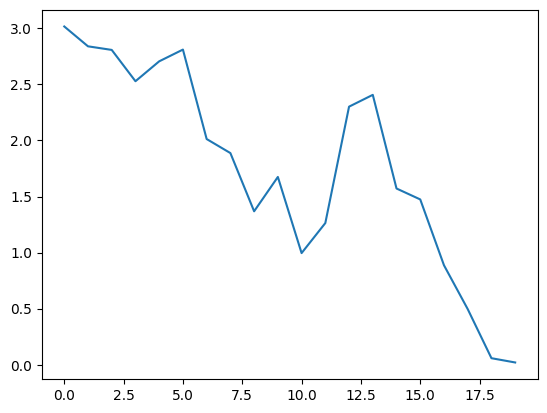

In [ ]:
plt.plot(dis_distances)

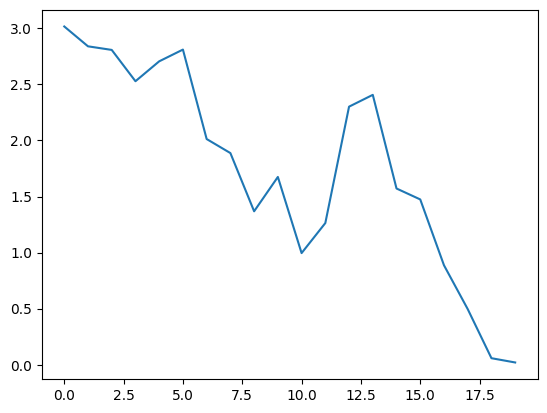

In [ ]:
plt.plot(dis_distances)

## Continuous case

In [ ]:
continous_truth = torch.tensor([
    [
        [0.2, 0.8, 0.1, 0.9],
        [0.3, 0.4, 0.2, 0.8]
    ],
    [
        [0.5, 0.7, 0.0, 0.1],
        [0.4, 0.8, 0.9, 1.0]
    ]
])

In [ ]:
batch, seq_len, pixels = continous_truth.shape

In [ ]:
def con_gamma(t, sigma_1):
  assert t > 0 and t <= 1, "time must be greater than 0 and less or equal to 1"
  return 1 - sigma_1 ** (2 * t)

In [ ]:
def con_mu(gamma, x):
  mean = gamma * x
  variance = gamma * (1 - gamma)
  epsilon = torch.normal(0, 1, x.shape)
  return mean + variance * epsilon

### Continous example with simulated bayesian inference for fast training

In [ ]:
sigma_1 = 0.001
t = 0.05
# normally we would sample uniformly a real from 0 to 1, with some minimum of
# say 1e-6 to prevent any possible divide by zero, but we hard-code for this example

In [ ]:
gamma = con_gamma(t, sigma_1)

In [ ]:
mu = con_mu(gamma, continous_truth)

### Continous Model

In [ ]:
def con_reparameterized_x_pred(model_output, mu, gamma):
  return (mu / gamma) - ((((1 - gamma) / gamma) ** 0.5) * model_output)

In [ ]:
class ContinuousModel(nn.Module):
  def __init__(self, max_seq_len: int, K: int, hidden_dim: int, num_heads: int, layers: int = 3, dropout: float = 0.1):
    super().__init__()
    assert hidden_dim % num_heads == 0, "hidden_dim must be divisble by num_heads"
    self.emb = nn.Parameter(torch.randn(K, hidden_dim))
    self.pos_emb = nn.Parameter(torch.randn(max_seq_len, hidden_dim))
    self.time_emb = nn.Parameter(torch.randn(1, hidden_dim))
    self.layers = nn.ModuleList(
        [
            nn.TransformerEncoderLayer(
                hidden_dim,
                num_heads,
                hidden_dim*4,
                dropout,
                batch_first=True,
                bias=False
                ) for i in range(layers)
        ]
    )
    self.classifier = nn.Parameter(torch.randn(hidden_dim, K))

  def token_emb(self, x):
    return x @ self.emb

  def positional_emb(self, x):
    return x + self.pos_emb[:x.shape[1]]

  def time_emb(self, x, t):
    assert t >= 0 and t <= 1, "time must be in range [0, 1]"


  def forward(self, x):
    x = self.token_emb(x)
    x = self.positional_emb(x)
    for i, l in enumerate(self.layers):
      x = l.forward(x)
    return x @ self.classifier

In [ ]:
con_model = ContinuousModel(seq_len, pixels, 64, 8)

In [ ]:
con_output = con_model(mu)

In [ ]:
con_output

tensor([[[  0.2347,  10.2422,   4.2242, -12.2003],
         [-10.2774,  -4.0376,   1.6303,  -5.2920]],

        [[  4.9822,   2.2075,  -0.2841, -13.3292],
         [ -1.2227,  -2.8514,   6.0360,   2.8248]]],
       grad_fn=<UnsafeViewBackward0>)

In [ ]:
con_x_prime = con_reparameterized_x_pred(con_output, mu, gamma)

In [ ]:
con_x_prime

tensor([[[-0.2479, -9.6577, -4.0247, 13.0770],
         [10.9774,  4.2358, -1.4098,  6.8574]],

        [[-4.2128, -1.2436,  0.1481, 13.7610],
         [ 1.3869,  3.8318, -4.9609, -2.1293]]], grad_fn=<SubBackward0>)

In [ ]:
continous_truth

tensor([[[0.2000, 0.8000, 0.1000, 0.9000],
         [0.3000, 0.4000, 0.2000, 0.8000]],

        [[0.5000, 0.7000, 0.0000, 0.1000],
         [0.4000, 0.8000, 0.9000, 1.0000]]])

In [ ]:
continous_truth - con_x_prime

tensor([[[  0.4479,  10.4577,   4.1247, -12.1770],
         [-10.6774,  -3.8358,   1.6098,  -6.0574]],

        [[  4.7128,   1.9436,  -0.1481, -13.6610],
         [ -0.9869,  -3.0318,   5.8609,   3.1293]]], grad_fn=<SubBackward0>)

In [ ]:
loss = -np.log(sigma_1) * ((torch.sum((continous_truth - con_x_prime) ** 2) / (sigma_1 ** (2 * t))) / batch)

In [ ]:
loss

tensor(4891.5361, grad_fn=<MulBackward0>)

### Continous Bayesian update

In [ ]:
def con_accuracy(sigma_1, i, n):
  assert n > 0, "Must have at least one inference step"
  assert i > 0, "Must be at the first inference step or later"
  assert i <= n, "Cannot be past last inference step"
  return (sigma_1 ** (-2 * i / n)) * (1 - sigma_1 ** (2 / n))

In [ ]:
def con_y(accuracy, x_prime):
  epsilon = torch.normal(0, 1, x_prime.shape)
  return x_prime + epsilon / accuracy

In [ ]:
def con_new_precision(accuracy, old_precision):
  return old_precision + accuracy

In [ ]:
def con_bayesian_update(old_precision, new_precision, accuracy, y, model_input):
  return (model_input * old_precision + y * accuracy) / new_precision

In [ ]:
def con_bayesian_inference(model_input, model_output_x_prime, sigma_1, i, n, precision):
  accuracy = con_accuracy(sigma_1, i, n)
  y = con_y(accuracy, model_output_x_prime)
  new_precision = con_new_precision(accuracy, precision)
  mu_prime = con_bayesian_update(precision, new_precision, accuracy, y, model_input)
  return mu_prime, new_precision

In [ ]:
torch.manual_seed(33)

In [ ]:
# we call this effective model output because the model actually outputes
# the noise epsilon' prediction rather than the x' prediction itself, however
# to simplify this example, we'll hard code the x' prediction directly
effective_model_output = continous_truth + 0.05 * torch.normal(0, 1, continous_truth.shape)

In [ ]:
model_input = torch.normal(0, 1, continous_truth.shape)

In [ ]:
precision = 0 # we start with zero precision

In [ ]:
sigma_1 = 0.001

In [ ]:
distances = []
n = 10

In [ ]:
for i in range(1, n+1):
  model_input, precision = con_bayesian_inference(model_input, effective_model_output, sigma_1, i, n, precision)
  mse = torch.sum((model_input - continous_truth) ** 2)
  distances.append(mse)

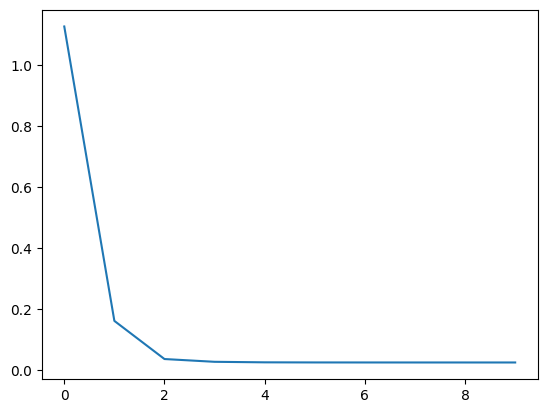

In [ ]:
plt.plot(distances)